In [1]:
%matplotlib inline

import pandas as pd
from sklearn.model_selection import cross_validate
from sklearn.dummy import DummyClassifier
from sklearn.pipeline import make_pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from joblib import dump, load
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB, ComplementNB
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import cohen_kappa_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from imblearn.pipeline import Pipeline 
from imblearn.pipeline import make_pipeline as make_pipeline_with_sampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTEENN
from sklearn.neighbors import KNeighborsClassifier
import operator
import logging
from sklearn.svm import SVC
from imblearn.over_sampling import RandomOverSampler 
from imblearn.over_sampling import SVMSMOTE
import statsmodels
from statsmodels.stats.inter_rater import cohens_kappa, to_table
from sklearn.linear_model import SGDClassifier
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek 
from sklearn import metrics
from pprint import pprint
from time import time
import re
import numpy as np
import logging
from sklearn.compose import make_column_transformer
from sklearn.compose import make_column_selector as selector

# Parts of the code adopted from Guillaume Lemaitre (https://imbalanced-learn.org/stable/auto_examples/applications/plot_impact_imbalanced_classes.html)

In [2]:
# Tweet text preprocessor

def tweet_preprocessing(x):
    # Remove all the special characters
    text = re.sub(r'\W', ' ', str(x))
    # remove all single characters
    text = re.sub(r'\s+[a-zA-Z]\s+', ' ', text)
    # Substituting multiple spaces with single space
    text= re.sub(r'\s+', ' ', text, flags=re.I)
    text = text.lower()
    text = ' '.join(re.sub("(@[a-zA-ZäöüÄÖÜß0-9]+)|([^0-9a-zA-ZäöüÄÖÜß \t])|(\w+:\/\/\S+)"," ",text).split())
    return(text)

In [3]:
# Stopword list including negative words

from nltk.corpus import stopwords
german_stop_words = stopwords.words('german')
for negation in ['nicht','nichts','gegen','für','keine', 'kein','keine','keinem','keinen', 'keiner','keines']:
    if negation in german_stop_words:
        german_stop_words.remove(negation)

In [4]:
# Load coded data

df = pd.read_csv("/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Vaccine Atttitude Classifier/Data/German Covid-19 Vaccination coding - coding_tweets_190521_chunk1.csv")
df = df[df['vaccine_stance'].notna()]
df.text = df.text.apply(lambda x: tweet_preprocessing(x))

In [5]:
# Given the low performance of prior tests including 3 classes, the classification task is changed to anti-vaccination view vs. the rest
df = df.replace({'vaccine_stance': {2: 1}})

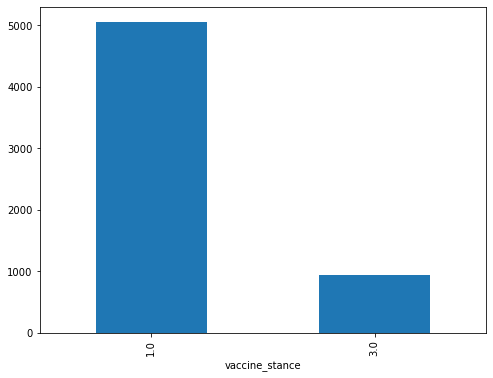

In [6]:
# Plot distribution (1 = Pro or Neutral, 3 = Anti)
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('vaccine_stance').text.count().plot.bar(ylim=0)
plt.show()

In [7]:
#Percentage of anti-vaccination tweets
100-df.groupby('vaccine_stance').vaccine_stance.value_counts()[1][1]/len(df)*100

15.793862575050028

In [8]:
# Calculate intercoder reliability

coder1 = list(pd.read_csv('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Vaccine Atttitude Classifier/Data/coder1.csv')['vaccine_stance'])

coder2 = list(pd.read_csv('/Users/D/Google Drive/UVA Arbeitsmaterial/2020:2021/Thesis/Thesis code/Vaccine Atttitude Classifier/Data/coder2.csv')['vaccine_stance'])

print(statsmodels.stats.inter_rater.cohens_kappa(confusion_matrix(coder1,coder2)))

                  Simple Kappa Coefficient
              --------------------------------
              Kappa                     0.8235
              ASE                       0.0384
              95% Lower Conf Limit      0.7482
              95% Upper Conf Limit      0.8988

                 Test of H0: Simple Kappa = 0

              ASE under H0              0.0533
              Z                         15.4392
              One-sided Pr >  Z         0.0000
              Two-sided Pr > |Z|        0.0000



In [9]:
# Inspect data
df

,id,text,vaccine_stance
0,1356642151397019653,und warum wurde in 30 jahren noch kein impfsto...,3.0
1,1364723771567988740,joelthuering parmeling schon dubios ein basler...,3.0
2,1324727450660671488,ndrmv warum bereitet mv nicht endlich präventi...,1.0
3,1355051921590071297,corona nachrichten weltweit von der leyen ford...,1.0
4,1365935602072510469,flugschulee so ist das mit den leerdenkern mit...,1.0
...,...,...,...
5998,1344543545848434690,rt bmauschen irgendwie scheint mir in den letz...,1.0
5999,1363273959089782786,rt bzbear2 hschaeferiw ich habe heute beim spa...,1.0
6000,1307238519987933193,https co wgcsqf0l75 zeitonline hat eine headli...,1.0
6001,1257380391595446284,scheibenkleister die erste serie auf netflix o...,1.0


In [10]:
#Split test and train sets
train, test = train_test_split(df, test_size=0.1)


# Create x and y for test and train data sets
df_res = train.drop(["vaccine_stance"], axis="columns").text
y_res = train.vaccine_stance.astype(int)

x_test = test.drop(["vaccine_stance"], axis="columns").text
y_test = test.vaccine_stance.astype(int)

# Print size of dataset and number of columns
print("Train data size: {}".format(train.shape))
print("Test data size: {}".format(test.shape))
print("Complete dataset size: {}".format(df.shape))

Train data size: (5396, 3)
Test data size: (600, 3)
Complete dataset size: (5996, 3)


In [11]:
# Scoring parameters to compare classifiers

scoring = ["precision", "balanced_accuracy",'f1','roc_auc']
index = []
scores = {"precision": [], "balanced accuracy": [], 'f1': [], 'roc_auc' : []}

def add_scores(x):
    scores["precision"].append(x["test_precision"].mean())
    scores["f1"].append(x["test_f1"].mean())
    scores["balanced accuracy"].append(x["test_balanced_accuracy"].mean())
    scores["roc_auc"].append(x["test_roc_auc"].mean())


In [12]:
# Baseline dummy classifier
dummy_clf = DummyClassifier(strategy="most_frequent")

index += ["Dummy classifier"]
cv_result = cross_validate(dummy_clf, df_res, y_res, scoring=scoring)
add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.839696,0.5,0.912864,0.5


In [13]:
# Logistic regression

text_pipe = Pipeline([('vect',  TfidfVectorizer( stop_words=german_stop_words,ngram_range=(1,2)))])
lr_clf = make_pipeline(text_pipe, LogisticRegression(max_iter=1000))

index += ["Logistic regression"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)

add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.839696,0.500000,0.912864,0.500000
Logistic regression,0.840238,0.502007,0.912447,0.723277


In [45]:
# MultinomialNB 

lr_clf = make_pipeline( TfidfVectorizer( stop_words=german_stop_words,ngram_range=(1,2)), MultinomialNB())

index += ["MultinomialNB"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)

add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226


In [46]:
# ComplementNB 

lr_clf = make_pipeline( TfidfVectorizer( stop_words=german_stop_words,ngram_range=(1,2)), ComplementNB())

index += ["ComplementNB"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)

add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226


In [47]:
# Logistic regression with balanced classes

lr_clf = make_pipeline( TfidfVectorizer( stop_words=german_stop_words,ngram_range=(1,2)), LogisticRegression(max_iter=1000, class_weight='balanced'))

index += ["Logistic regression with balanced class weights"]
cv_result = cross_validate(lr_clf, df_res, y_res, scoring=scoring)

add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226
Logistic regression with balanced class weights,0.890128,0.643731,0.861505,0.732839


In [48]:
rf_clf = make_pipeline( TfidfVectorizer( stop_words=german_stop_words,ngram_range=(1,2)), RandomForestClassifier( class_weight='balanced'))

index += ["Random forest with balanced class weights"]
cv_result = cross_validate(rf_clf, df_res, y_res, scoring=scoring)
add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226
Logistic regression with balanced class weights,0.890128,0.643731,0.861505,0.732839
Random forest with balanced class weights,0.843112,0.505848,0.914879,0.690908


In [49]:
smote_clf = make_pipeline_with_sampler(
    TfidfVectorizer(stop_words=german_stop_words,ngram_range=(1,2)),
    SMOTETomek(random_state=0, sampling_strategy='minority'),
     LogisticRegression(max_iter=1000, class_weight='balanced')
    # AdaBoostClassifier(),
)

index += ["Log Regression balanced classes + SMOTETomek"]
cv_result = cross_validate(smote_clf, df_res, y_res, scoring=scoring)
add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226
Logistic regression with balanced class weights,0.890128,0.643731,0.861505,0.732839
Random forest with balanced class weights,0.843112,0.505848,0.914879,0.690908
Log Regression balanced classes + SMOTETomek,0.884764,0.631266,0.867966,0.732818


In [50]:
smote_clf = make_pipeline_with_sampler(
    TfidfVectorizer(stop_words=german_stop_words,ngram_range=(1,2)),
    SMOTETomek(random_state=0, sampling_strategy='minority'),
    SVC(gamma=2, C=1)
)

index += ["SVC + SMOTETomek"]
cv_result = cross_validate(smote_clf, df_res, y_res, scoring=scoring)
add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226
Logistic regression with balanced class weights,0.890128,0.643731,0.861505,0.732839
Random forest with balanced class weights,0.843112,0.505848,0.914879,0.690908
Log Regression balanced classes + SMOTETomek,0.884764,0.631266,0.867966,0.732818
SVC + SMOTETomek,0.842800,0.504678,0.914695,0.725527


In [ ]:
# Find final estimator by hyperparameter tuning the best performing models

parameters = [
    {'clf': [ComplementNB()],
     'vec__ngram_range': [(1, 1), (1, 2),(1,4)],
     'clf__alpha': [0.001, 0.1, 1, 10, 100]
    },
    { 'clf': [SVC()],
     'vec__ngram_range': [(1, 1), (1, 2),(1,4)],
     'clf__C': [0.001, 0.1, 1, 10, 100, 10e5],
    # 'clf__kernel': ['linear', 'rbf'],
    # 'clf__probability': [True]
    },
    {'clf': [LogisticRegression(class_weight='balanced')],
     'vec__ngram_range': [(1, 1), (1, 2),(1,3),(1,4)],
      'clf__solver': ['lbfgs','saga'],
    }
    ]

result=[]

for params in parameters:
    clf = params['clf'][0]
    params.pop('clf')   
    steps = [('vec', TfidfVectorizer(stop_words=german_stop_words)), 
             ('smote', SMOTETomek(random_state=0, sampling_strategy='minority'),),
             ('clf',clf)]
    grid = GridSearchCV(Pipeline(steps), param_grid=params, cv=5, n_jobs=-1, scoring='roc_auc')
    grid.fit(df_res, y_res)

    result.append({
        'grid': grid,
        'classifier': grid.best_estimator_,
        'best score': grid.best_score_,
        'best params': grid.best_params_,
        'cv': grid.cv})

result = sorted(result, key=operator.itemgetter('best score'),reverse=True)
grid = result[0]['grid']

In [46]:
grid.best_estimator_

Pipeline(steps=[('vec',
                 TfidfVectorizer(stop_words=['aber', 'alle', 'allem', 'allen',
                                             'aller', 'alles', 'als', 'also',
                                             'am', 'an', 'ander', 'andere',
                                             'anderem', 'anderen', 'anderer',
                                             'anderes', 'anderm', 'andern',
                                             'anderr', 'anders', 'auch', 'auf',
                                             'aus', 'bei', 'bin', 'bis', 'bist',
                                             'da', 'damit', 'dann', ...])),
                ('smote',
                 SMOTETomek(random_state=0, sampling_strategy='minority')),
                ('clf', SVC(C=10))])

In [51]:
# Test best settings across different scoring parameters (Seperated from step above to reduce duration of calculation)

smote_clf = make_pipeline_with_sampler(
    TfidfVectorizer(stop_words=german_stop_words,ngram_range=(1,4)),
    SMOTETomek(random_state=0, sampling_strategy='minority'),
    ComplementNB(alpha=1)
)

index += ["Hyperparameter tuned SMOTE ComplementNB"]
cv_result = cross_validate(smote_clf, df_res, y_res, scoring=scoring)
add_scores(cv_result)
df_scores = pd.DataFrame(scores, index=index)
df_scores

,precision,balanced accuracy,f1,roc_auc
Dummy classifier,0.841549,0.500000,0.913958,0.500000
Logistic regression,0.842342,0.502958,0.913964,0.728112
MultinomialNB,0.841549,0.500000,0.913958,0.609226
ComplementNB,0.843251,0.506357,0.914407,0.609226
Logistic regression with balanced class weights,0.890128,0.643731,0.861505,0.732839
Random forest with balanced class weights,0.843112,0.505848,0.914879,0.690908
Log Regression balanced classes + SMOTETomek,0.884764,0.631266,0.867966,0.732818
SVC + SMOTETomek,0.842800,0.504678,0.914695,0.725527
Hyperparameter tuned SMOTE ComplementNB,0.919576,0.677809,0.771415,0.734540


In [34]:
best_clf = smote_clf.fit( df_res, y_res)
predicted = best_clf.predict(x_test)
# Percentage of rightly classified cases
np.mean(predicted == y_test)
print(metrics.classification_report(y_test, predicted))

              precision    recall  f1-score   support

           1       1.00      0.96      0.98       513
           3       0.79      0.98      0.88        87

    accuracy                           0.96       600
   macro avg       0.90      0.97      0.93       600
weighted avg       0.97      0.96      0.96       600



In [35]:
# Function adopted from Yash Nag (https://stackoverflow.com/questions/39662398/scikit-learn-output-metrics-classification-report-into-csv-tab-delimited-format)
def report_to_df(report):
    report = [x.split(' ') for x in report.split('\n')]
    header = ['Class Name']+[x for x in report[0] if x!='']
    values = []
    for row in report[1:-5]:
        row = [value for value in row if value!='']
        if row!=[]:
            values.append(row)
    df = pd.DataFrame(data = values, columns = header)
    return df

In [37]:
report = report_to_df(metrics.classification_report(y_test, predicted)).replace({'Class Name': {'1': 'Pro/ Neutral', '3':'Anti-Vaccination'}})
print(report)

with open('/Users/D/Dropbox/Apps/Overleaf/Master_thesis_010621/tables/classification_report.tex','w') as tf:
    tf.write(report.to_latex(header=['Class','Precision','Recall','F1-Score','Support'], float_format="{:0.2f}".format ,index=False,
    caption='Classification report for the machine learning classifier model.'))

         Class Name precision recall f1-score support
0      Pro/ Neutral      1.00   0.96     0.98     513
1  Anti-Vaccination      0.79   0.98     0.88      87


In [31]:
# Save  best classifier model
dump(best_clf, 'vaccine_stance_clf.joblib') 

['vaccine_stance_clf.joblib']

In [32]:
### Classify tweets the overall dataset

In [33]:
# Load classifier and data
clf = load('vaccine_stance_clf.joblib') 
data = pd.read_pickle('/Users/D/final_edgelist_180521.pkl') 

In [36]:
# Apply preprocessing to tweet text and predict vaccination stance based on text
data['vaccine_stance'] =  clf.predict(data.text.apply(lambda x: (tweet_preprocessing(x))))

In [37]:
# score 0 = neutral, 1 = anti vaccine
data = data.replace({'vaccine_stance': {1: 0, 3: 1}})

In [38]:
data.vaccine_stance.value_counts()

0    2130417
1    1136899
Name: vaccine_stance, dtype: int64

In [39]:
# Vaccination stance per author
author_stance = data.groupby('author_id')['vaccine_stance'].agg(['mean','count'])
def cat(x):
    if x <= np.float(0.5):
        return "pro_neutral"
    else:
        return "anti_vaxx"
author_stance['vaccine_stance'] = author_stance['mean'].apply(lambda x: cat(x))

#Export author vaccine stances
author_stance.to_pickle('authors_vaccination_stance_ML_results.pkl')

In [40]:
author_stance.vaccine_stance.value_counts()

pro_neutral    268034
anti_vaxx       79259
Name: vaccine_stance, dtype: int64